
Тестовий пакет – MIRFlickr-20k (https://press.liacs.nl/mirflickr/#sec_download)
Вибірка зображень – 250 зображень;
Формування вибірки зображень – псевдовипадкове, з використанням генератора Мерсена (стартове значення співпадає з номером студента в загальному списку групи) за модулем кількості зображень в тестовому пакеті.

#### Лабораторна робота №2
	Сформувати тестову вибірку зображень з вихідного пакету;

In [1]:
import numpy as np
import pandas as pd

import os
import cv2
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

os.chdir('C:\\DS\\datasets\\mirflickr')# all datasets will be stored outside of a project
total_students = 10
student_num = 3%total_students

To select a sample we'll use numpy.random module, an implementation of Mersenne Twister pseudorandom generator based on [MT19937 algorithm](https://en.wikipedia.org/wiki/Mersenne_Twister). It's worth mentioning that python's random module is identical

In [2]:
contents = os.listdir()
images_names = np.array([c for c in contents if c.endswith('.jpg')])

# np.seed(student_num)
generator = np.random.RandomState(seed=student_num)# works the same as np.seed()

total_images = images_names.shape[0]
sample_size = 250

sample_images_names = generator.choice(images_names,sample_size) 

print(f'selected sample {sample_size} of images from {total_images} images in total')

selected sample 250 of images from 25000 images in total


To read the images we'll use opencv, which by default reads image in B,G,R order. 
* cv.imread(file) reads image as an ndarray of shape (height,width,3)
* cv.split() split ndarray into three 2D arrays (B,G,R) of shape (height,width), from which we select array G

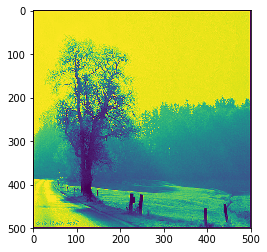

In [3]:
#sample_images = np.array([cv2.imread(img) for img in sample_images_names])
sample_images_green = np.array([cv2.split(cv2.imread(img))[1] for img in sample_images_names])
#green_pixels_list = np.concatenate([img.flatten() for img in sample_images_green])

plt.imshow(sample_images_green[34]);

* 1) 	Провести декомпозицію каналу зеленого кольору тестових зображень з використанням методу головних компонент (PCA):

In [4]:
def apply_pca(image,components=None, inverse_transform = True):
    """
        Applies PCA using a certain number of components, returns reconstructed image
    """
    pca = PCA(n_components=components,svd_solver='full')
    compressed = pca.fit_transform(image)
    if inverse_transform:
        return pca.inverse_transform(compressed)
    return pca,compressed

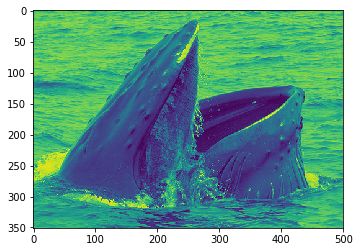

In [5]:
reconstructed = apply_pca(sample_images_green[123])
plt.imshow(reconstructed);

2) 	Для каналу зеленого кольору тестових зображень обчислити наступні характеристики розподілу значень яскравості пікселів:
*	Впорядкувати отримані компоненти вихідного зображення в порядку зменшення значень сингулярних чисел (від найбільшого $s_{max}$ до найменшого $s_{min}$ значення);


In [6]:
np.set_printoptions(suppress=True)
pca,compressed_img = apply_pca(sample_images_green[123],inverse_transform=False)
pca.singular_values_

array([17288.06481012,  6327.51092025,  5576.63578905,  4901.65362791,
        4005.84547504,  3514.05689445,  2543.74432848,  2422.48356279,
        2372.64626076,  2315.92439261,  2037.40621949,  1939.87481477,
        1877.97738145,  1688.92916824,  1635.74859407,  1603.75711041,
        1519.75741795,  1466.19728318,  1425.9948508 ,  1405.04626472,
        1387.95141975,  1314.67726694,  1297.55625651,  1285.58665575,
        1256.88171834,  1229.17571037,  1178.52157012,  1170.13803792,
        1155.62123429,  1125.85139679,  1102.92723183,  1080.69033804,
        1062.52704146,  1023.03138146,  1007.04202169,   999.14158013,
         981.62868101,   962.59841462,   936.81103649,   929.89756445,
         911.16234479,   897.05575023,   889.52756309,   873.82509481,
         852.16372078,   839.91592077,   832.44439716,   826.72909916,
         807.52616554,   798.39118816,   789.84629595,   775.89077635,
         760.906167  ,   753.5060004 ,   740.64133182,   733.41675161,
      

*	Провести реконструкцію зображення при використанні лише частки (α%) компонентів розкладу, що характеризуються відмінними від нуля сингулярними числами ($s_i≠0$). Розглянути випадок, коли α змінюється від $α_{min}=10\%$ до $α_{max}=100\%$ з кроком $∆_α=10\%$
*	Порівняти вихідне та реконструйоване зображення за показником середньоквадратичного відхилення (MSE). 

In [7]:
np.set_printoptions(suppress=False)
def reconstruct(image):
    mse = np.array([mean_squared_error(image,apply_pca(image,components=alpha*0.1 if alpha<10 else None)) for alpha in range(1,11)])
    return mse
mse = reconstruct(sample_images_green[123])
mse

array([1.35190003e+03, 1.35190003e+03, 1.35190003e+03, 1.35190003e+03,
       1.35190003e+03, 1.12376673e+03, 8.09663737e+02, 5.77558577e+02,
       2.97883966e+02, 2.01299863e-25])

*	Побудувати графіки залежності ($\overline {MSE}$(α)), де $\overline {MSE}$ - значення середньо-квадратичного відхилення між вихідним та реконструйованим зображеннями, усереднені по тестовому пакету;

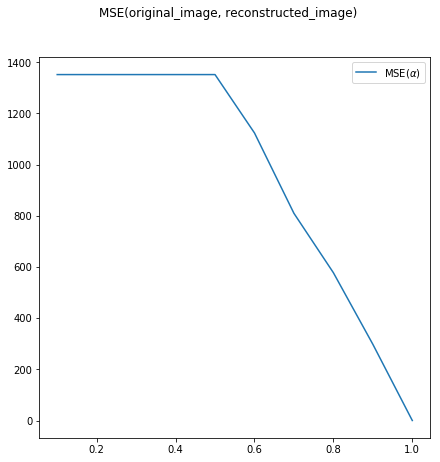

In [8]:
plt.figure(figsize=(7,7))
plt.suptitle("MSE(original_image, reconstructed_image)")
plt.plot(np.arange(0.1,1.1,0.1),mse,label='MSE($\\alpha$)')
plt.legend();

* 4) 	Провести моделювання каналу зеленого кольору тестових зображень з використанням марківських ланцюгів першого порядку $M_1$:
    *	Отримати стохастичну матрицю для каналу зеленого кольору при обробці пікселів (згідно номеру студента в списку групи, за модулем кількості варіантів):
        *	По горизонталі, зліва направо – M_1^→ (I_(x,y),I_(x+1,y) );
        *	По горизонталі, справа наліво – M_1^← (I_(x,y),I_(x-1,y) );
        *	По вертикалі, зверху вниз – M_1^↓ (I_(x,y),I_(x,y+1) );
        *	По вертикалі, знизу вгору – M_1^↑ (I_(x,y),I_(x,y-1) );
        *	По головній діагоналі – M_1^↘ (I_(x,y),I_(x+1,y+1) );
        *	По головній діагоналі – M_1^↖ (I_(x,y),I_(x-1,y-1) );
        *	По побічній діагоналі – M_1^↙ (I_(x,y),I_(x-1,y+1) );
        *	По побічній діагоналі – M_1^↗ (I_(x,y),I_(x+1,y-1) );
*	В протоколі роботи графічно показати вид марківського ланцюга для діапазону яскравості пікселів I_(x,y)∈[i;i×10], де i- номеру студента в списку групи;
*	Для отриманих марківських ланцюгів перевірити виконання властивості регулярності та рекурентності після проходження 5 ітерацій роботи.

